In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os
import xgboost as xgb
import shap
from sklearn.metrics import auc, roc_curve
from scripts.optuna_tuning import objective
import optuna

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10//2, 60//2, 60*5//2]

In [3]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset/'))

static = pd.read_parquet('data/datasets/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)
    

train = data[data['split'] == 1]
test = data[data['split'] == 0]

In [6]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve
from scripts.optuna_tuning import objective
import optuna

n_bootstraps = 200
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)


tpr_list, auc_list, thr_list  = [], [], []
tpr_train, auc_train  = [], []
sensitivity_list, specificity_list, ppv_list, npv_list = [], [], [], []
fpr = np.linspace(0, 1, 100)

FEATURE_NAME = [f'{signal}_ema_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + [f'{signal}_std_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + STATIC_FEATURE



# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)
print(f'{len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}')

# try to open the model
try:
    model = xgb.XGBClassifier()
    model.load_model(f'data/models/xgb.json')
except:

    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train, FEATURE_NAME), n_trials=100, show_progress_bar=True, )
    # get the best hyperparameters
    best_params = study.best_params
    # ret
    #refit the model with best parameters
    model = xgb.XGBClassifier(**best_params)
    model.fit(train[FEATURE_NAME], train.label, verbose=1)
    #save the model
    model.save_model(f'data/models/xgb.json')

# get training auc
y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
y_train = train['label'].values
fpr_, tpr_, _ = roc_curve(y_train, y_pred)
auc_train = auc(fpr_, tpr_)

tpr_train = np.interp(np.linspace(0, 1, 100), fpr_, tpr_)

y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test['label'].values

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    fpr_, tpr_, thr_ = roc_curve(y_test[indices], y_pred[indices])
    auc_ = auc(fpr_, tpr_)
    gmean = np.sqrt(tpr_ * (1-fpr_))
    id_thresh_opt = np.argmax(gmean)
    sensitivity_list.append(tpr_[id_thresh_opt]*100)
    specificity_list.append((1-fpr_[id_thresh_opt])*100)
    prevalence = np.mean(y_test[indices])
    ppv_list.append(100 * tpr_[id_thresh_opt]*prevalence / (tpr_[id_thresh_opt]*prevalence + fpr_[id_thresh_opt]*(1-prevalence)))
    npv_list.append(100 * (1-fpr_[id_thresh_opt])*(1-prevalence) / ((1-tpr_[id_thresh_opt])*prevalence + (1-fpr_[id_thresh_opt])*(1-prevalence)))


    tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, tpr_))
    thr_list.append(np.interp(np.linspace(0, 1, 100), fpr_, thr_))
    auc_list.append(auc_)  


# compute mean ROC curve
tpr_mean = np.mean(tpr_list, axis=0)
tpr_std = np.std(tpr_list, axis=0)
thr_mean = np.mean(thr_list, axis=0)
sensi_mean = np.mean(sensitivity_list)
speci_mean = np.mean(specificity_list)
ppv_mean = np.mean(ppv_list)
npv_mean = np.mean(npv_list)
sensi_std = np.std(sensitivity_list)
speci_std = np.std(specificity_list)
ppv_std = np.std(ppv_list)
npv_std = np.std(npv_list)

# save the ROC curve
df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr_mean,
    'tpr_std':tpr_std,
    'threshold': thr_mean,
    'auc': np.round(np.mean(auc_list),2),
    'auc_std': np.round(pd.Series(auc_list).std(),2),
        'sensitivity': sensi_mean,
    'sensitivity_std': sensi_std,
    'specificity': speci_mean,
    'specificity_std': speci_std,
    'ppv': ppv_mean,
    'ppv_std': ppv_std,
    'npv': npv_mean,
    'npv_std': npv_std,
})
df.to_csv('data/results/xgboost_roc.csv', index=False)


[I 2024-03-06 16:28:56,546] A new study created in memory with name: no-name-0cd894e6-db51-4873-86d1-190f7c1aa42d


91141 train samples and 38496 test samples, positive rate = 0.06


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.79677:   1%|          | 1/100 [00:14<23:44, 14.38s/it]

[I 2024-03-06 16:29:10,928] Trial 0 finished with value: 0.796769648085473 and parameters: {'max_depth': 5, 'learning_rate': 0.022028914470378205, 'n_estimators': 425, 'min_child_weight': 4, 'gamma': 0.00018593403559549087, 'subsample': 0.8071464055232511}. Best is trial 0 with value: 0.796769648085473.


Best trial: 1. Best value: 0.805057:   2%|▏         | 2/100 [00:37<31:33, 19.32s/it]

[I 2024-03-06 16:29:33,699] Trial 1 finished with value: 0.8050566115157746 and parameters: {'max_depth': 7, 'learning_rate': 0.002048741822341203, 'n_estimators': 304, 'min_child_weight': 2, 'gamma': 0.21557299154824447, 'subsample': 0.6075559150423738}. Best is trial 1 with value: 0.8050566115157746.


Best trial: 1. Best value: 0.805057:   3%|▎         | 3/100 [00:41<19:55, 12.32s/it]

[I 2024-03-06 16:29:37,700] Trial 2 finished with value: 0.7999524022687842 and parameters: {'max_depth': 2, 'learning_rate': 0.010470879709880017, 'n_estimators': 141, 'min_child_weight': 7, 'gamma': 1.8909546608067055e-08, 'subsample': 0.6472209705287512}. Best is trial 1 with value: 0.8050566115157746.


Best trial: 1. Best value: 0.805057:   4%|▍         | 4/100 [00:58<22:40, 14.17s/it]

[I 2024-03-06 16:29:54,702] Trial 3 finished with value: 0.7710246790669509 and parameters: {'max_depth': 6, 'learning_rate': 0.046877293803192936, 'n_estimators': 373, 'min_child_weight': 3, 'gamma': 4.824218204677546e-05, 'subsample': 0.7249871578120797}. Best is trial 1 with value: 0.8050566115157746.


Best trial: 1. Best value: 0.805057:   5%|▌         | 5/100 [01:03<17:23, 10.98s/it]

[I 2024-03-06 16:30:00,023] Trial 4 finished with value: 0.800495675256884 and parameters: {'max_depth': 9, 'learning_rate': 0.002240548199799796, 'n_estimators': 53, 'min_child_weight': 8, 'gamma': 1.118804604612587e-06, 'subsample': 0.6991323180487814}. Best is trial 1 with value: 0.8050566115157746.


Best trial: 1. Best value: 0.805057:   6%|▌         | 6/100 [01:06<13:07,  8.38s/it]

[I 2024-03-06 16:30:03,342] Trial 5 finished with value: 0.779568867650901 and parameters: {'max_depth': 1, 'learning_rate': 0.01159328928036827, 'n_estimators': 179, 'min_child_weight': 3, 'gamma': 1.0934208420642021e-05, 'subsample': 0.6753386360091376}. Best is trial 1 with value: 0.8050566115157746.


Best trial: 1. Best value: 0.805057:   7%|▋         | 7/100 [01:10<10:45,  6.95s/it]

[I 2024-03-06 16:30:07,339] Trial 6 finished with value: 0.7492684472547557 and parameters: {'max_depth': 1, 'learning_rate': 0.003432458808223249, 'n_estimators': 240, 'min_child_weight': 7, 'gamma': 3.0720744632370434e-06, 'subsample': 0.9399485840563798}. Best is trial 1 with value: 0.8050566115157746.


Best trial: 7. Best value: 0.813399:   8%|▊         | 8/100 [01:24<13:45,  8.97s/it]

[I 2024-03-06 16:30:20,662] Trial 7 finished with value: 0.8133989231023095 and parameters: {'max_depth': 2, 'learning_rate': 0.01730273760424456, 'n_estimators': 322, 'min_child_weight': 6, 'gamma': 2.54619546824254e-07, 'subsample': 0.9039161814044075}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:   9%|▉         | 9/100 [02:17<34:54, 23.01s/it]

[I 2024-03-06 16:31:14,541] Trial 8 finished with value: 0.8047786037538615 and parameters: {'max_depth': 7, 'learning_rate': 0.0032771722674381607, 'n_estimators': 481, 'min_child_weight': 2, 'gamma': 4.7037190073121485e-05, 'subsample': 0.9442881901779391}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  10%|█         | 10/100 [02:29<29:06, 19.40s/it]

[I 2024-03-06 16:31:25,854] Trial 9 finished with value: 0.8010062647198802 and parameters: {'max_depth': 4, 'learning_rate': 0.021661789738192223, 'n_estimators': 426, 'min_child_weight': 8, 'gamma': 5.1415727716149394e-08, 'subsample': 0.8477810870768382}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  11%|█         | 11/100 [02:35<22:58, 15.48s/it]

[I 2024-03-06 16:31:32,456] Trial 10 finished with value: 0.7904975818581557 and parameters: {'max_depth': 3, 'learning_rate': 0.06518320116714207, 'n_estimators': 307, 'min_child_weight': 10, 'gamma': 0.025168158399728014, 'subsample': 0.9987401037155044}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  12%|█▏        | 12/100 [03:07<30:05, 20.52s/it]

[I 2024-03-06 16:32:04,505] Trial 11 finished with value: 0.802569971485669 and parameters: {'max_depth': 8, 'learning_rate': 0.0011774483351131729, 'n_estimators': 312, 'min_child_weight': 1, 'gamma': 0.2770807719205985, 'subsample': 0.6162043214723256}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  13%|█▎        | 13/100 [03:21<26:45, 18.45s/it]

[I 2024-03-06 16:32:18,187] Trial 12 finished with value: 0.8084742425765835 and parameters: {'max_depth': 6, 'learning_rate': 0.0057997109739026855, 'n_estimators': 254, 'min_child_weight': 5, 'gamma': 0.002732740142788017, 'subsample': 0.7656163840385447}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  14%|█▍        | 14/100 [03:28<21:17, 14.85s/it]

[I 2024-03-06 16:32:24,726] Trial 13 finished with value: 0.8082660194601092 and parameters: {'max_depth': 4, 'learning_rate': 0.0063988291281910775, 'n_estimators': 226, 'min_child_weight': 5, 'gamma': 0.0024830097370808204, 'subsample': 0.8597229064951949}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  15%|█▌        | 15/100 [03:40<19:52, 14.04s/it]

[I 2024-03-06 16:32:36,867] Trial 14 finished with value: 0.7955387937424341 and parameters: {'max_depth': 5, 'learning_rate': 0.024854375859306554, 'n_estimators': 363, 'min_child_weight': 6, 'gamma': 0.001254595300227194, 'subsample': 0.7775091960264471}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  16%|█▌        | 16/100 [03:44<15:26, 11.03s/it]

[I 2024-03-06 16:32:40,910] Trial 15 finished with value: 0.8041264824347613 and parameters: {'max_depth': 3, 'learning_rate': 0.006881467207410925, 'n_estimators': 135, 'min_child_weight': 5, 'gamma': 1.2134596866837395e-07, 'subsample': 0.7436336866264578}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  17%|█▋        | 17/100 [03:54<14:57, 10.82s/it]

[I 2024-03-06 16:32:51,242] Trial 16 finished with value: 0.7908554299011765 and parameters: {'max_depth': 6, 'learning_rate': 0.03794202471790495, 'n_estimators': 241, 'min_child_weight': 6, 'gamma': 0.0020753850627483047, 'subsample': 0.8689888776708493}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 7. Best value: 0.813399:  18%|█▊        | 18/100 [04:03<13:59, 10.24s/it]

[I 2024-03-06 16:33:00,131] Trial 17 finished with value: 0.8128788220364395 and parameters: {'max_depth': 3, 'learning_rate': 0.015424787524976643, 'n_estimators': 363, 'min_child_weight': 10, 'gamma': 0.01939184082344074, 'subsample': 0.824831319901823}. Best is trial 7 with value: 0.8133989231023095.


Best trial: 18. Best value: 0.813593:  19%|█▉        | 19/100 [04:10<12:32,  9.30s/it]

[I 2024-03-06 16:33:07,232] Trial 18 finished with value: 0.8135933447349256 and parameters: {'max_depth': 2, 'learning_rate': 0.015520750198614753, 'n_estimators': 374, 'min_child_weight': 10, 'gamma': 2.2985024471648134e-07, 'subsample': 0.8940687023297561}. Best is trial 18 with value: 0.8135933447349256.


Best trial: 18. Best value: 0.813593:  20%|██        | 20/100 [04:19<12:03,  9.04s/it]

[I 2024-03-06 16:33:15,671] Trial 19 finished with value: 0.8073307117759505 and parameters: {'max_depth': 2, 'learning_rate': 0.04326637427941689, 'n_estimators': 499, 'min_child_weight': 9, 'gamma': 4.521203607144426e-07, 'subsample': 0.9104233712326109}. Best is trial 18 with value: 0.8135933447349256.


Best trial: 18. Best value: 0.813593:  21%|██        | 21/100 [04:25<10:59,  8.35s/it]

[I 2024-03-06 16:33:22,418] Trial 20 finished with value: 0.7996397627003103 and parameters: {'max_depth': 2, 'learning_rate': 0.08016557354076932, 'n_estimators': 414, 'min_child_weight': 9, 'gamma': 1.1711617567930573e-08, 'subsample': 0.9978927254670311}. Best is trial 18 with value: 0.8135933447349256.


Best trial: 18. Best value: 0.813593:  22%|██▏       | 22/100 [04:33<10:42,  8.23s/it]

[I 2024-03-06 16:33:30,371] Trial 21 finished with value: 0.8121268978466709 and parameters: {'max_depth': 3, 'learning_rate': 0.016150495109585866, 'n_estimators': 369, 'min_child_weight': 10, 'gamma': 2.8009006503882083e-07, 'subsample': 0.8200607091337594}. Best is trial 18 with value: 0.8135933447349256.


Best trial: 18. Best value: 0.813593:  23%|██▎       | 23/100 [04:39<09:32,  7.44s/it]

[I 2024-03-06 16:33:35,967] Trial 22 finished with value: 0.8061044105627637 and parameters: {'max_depth': 1, 'learning_rate': 0.015875749576393126, 'n_estimators': 343, 'min_child_weight': 9, 'gamma': 4.98019005806968e-06, 'subsample': 0.9070107401491074}. Best is trial 18 with value: 0.8135933447349256.


Best trial: 18. Best value: 0.813593:  24%|██▍       | 24/100 [04:51<11:19,  8.94s/it]

[I 2024-03-06 16:33:48,413] Trial 23 finished with value: 0.7954878096764704 and parameters: {'max_depth': 4, 'learning_rate': 0.030008958940786715, 'n_estimators': 389, 'min_child_weight': 10, 'gamma': 0.0003883732269751453, 'subsample': 0.8832977220531234}. Best is trial 18 with value: 0.8135933447349256.


Best trial: 24. Best value: 0.813618:  25%|██▌       | 25/100 [05:00<10:55,  8.74s/it]

[I 2024-03-06 16:33:56,669] Trial 24 finished with value: 0.8136176753813064 and parameters: {'max_depth': 2, 'learning_rate': 0.01424912255496332, 'n_estimators': 452, 'min_child_weight': 8, 'gamma': 0.023514598792562975, 'subsample': 0.8135182601955665}. Best is trial 24 with value: 0.8136176753813064.


Best trial: 24. Best value: 0.813618:  26%|██▌       | 26/100 [05:07<10:17,  8.35s/it]

[I 2024-03-06 16:34:04,112] Trial 25 finished with value: 0.8126044466445537 and parameters: {'max_depth': 2, 'learning_rate': 0.009553259243543574, 'n_estimators': 467, 'min_child_weight': 8, 'gamma': 0.919694245698208, 'subsample': 0.7862185487600352}. Best is trial 24 with value: 0.8136176753813064.


Best trial: 24. Best value: 0.813618:  27%|██▋       | 27/100 [05:12<08:49,  7.26s/it]

[I 2024-03-06 16:34:08,820] Trial 26 finished with value: 0.803022738371005 and parameters: {'max_depth': 1, 'learning_rate': 0.00977203807033597, 'n_estimators': 446, 'min_child_weight': 7, 'gamma': 1.2656990358894956e-05, 'subsample': 0.944786438419496}. Best is trial 24 with value: 0.8136176753813064.


Best trial: 24. Best value: 0.813618:  28%|██▊       | 28/100 [05:18<08:25,  7.02s/it]

[I 2024-03-06 16:34:15,281] Trial 27 finished with value: 0.7993424830997254 and parameters: {'max_depth': 2, 'learning_rate': 0.004385782378707274, 'n_estimators': 325, 'min_child_weight': 8, 'gamma': 1.081893618215883e-06, 'subsample': 0.8990242793290893}. Best is trial 24 with value: 0.8136176753813064.


Best trial: 24. Best value: 0.813618:  29%|██▉       | 29/100 [05:26<08:26,  7.14s/it]

[I 2024-03-06 16:34:22,699] Trial 28 finished with value: 0.8122808310667154 and parameters: {'max_depth': 4, 'learning_rate': 0.01565169403050898, 'n_estimators': 282, 'min_child_weight': 9, 'gamma': 5.395987570270818e-08, 'subsample': 0.8472045795660866}. Best is trial 24 with value: 0.8136176753813064.


Best trial: 24. Best value: 0.813618:  30%|███       | 30/100 [05:36<09:35,  8.22s/it]

[I 2024-03-06 16:34:33,448] Trial 29 finished with value: 0.8079848381816479 and parameters: {'max_depth': 3, 'learning_rate': 0.02230787714109151, 'n_estimators': 431, 'min_child_weight': 6, 'gamma': 0.00019711323813893913, 'subsample': 0.796488230155921}. Best is trial 24 with value: 0.8136176753813064.


Best trial: 30. Best value: 0.813657:  31%|███       | 31/100 [05:44<09:11,  8.00s/it]

[I 2024-03-06 16:34:40,920] Trial 30 finished with value: 0.8136572259565545 and parameters: {'max_depth': 1, 'learning_rate': 0.030470573670948384, 'n_estimators': 399, 'min_child_weight': 4, 'gamma': 0.014825425404823572, 'subsample': 0.8276297396652925}. Best is trial 30 with value: 0.8136572259565545.


Best trial: 31. Best value: 0.813958:  32%|███▏      | 32/100 [05:51<08:37,  7.61s/it]

[I 2024-03-06 16:34:47,628] Trial 31 finished with value: 0.8139582108244059 and parameters: {'max_depth': 1, 'learning_rate': 0.031677804081291165, 'n_estimators': 403, 'min_child_weight': 4, 'gamma': 0.023527233824912595, 'subsample': 0.8200067674958941}. Best is trial 31 with value: 0.8139582108244059.


Best trial: 31. Best value: 0.813958:  33%|███▎      | 33/100 [05:58<08:28,  7.59s/it]

[I 2024-03-06 16:34:55,158] Trial 32 finished with value: 0.8136525889246977 and parameters: {'max_depth': 1, 'learning_rate': 0.030111874421819028, 'n_estimators': 396, 'min_child_weight': 4, 'gamma': 0.012309820502663736, 'subsample': 0.8242238181970356}. Best is trial 31 with value: 0.8139582108244059.


Best trial: 33. Best value: 0.815325:  34%|███▍      | 34/100 [06:09<09:25,  8.57s/it]

[I 2024-03-06 16:35:06,011] Trial 33 finished with value: 0.8153246714856038 and parameters: {'max_depth': 1, 'learning_rate': 0.06103985240636543, 'n_estimators': 398, 'min_child_weight': 4, 'gamma': 0.022789704879737464, 'subsample': 0.8202829545654218}. Best is trial 33 with value: 0.8153246714856038.


Best trial: 34. Best value: 0.816104:  35%|███▌      | 35/100 [06:15<08:26,  7.80s/it]

[I 2024-03-06 16:35:12,016] Trial 34 finished with value: 0.8161039086226403 and parameters: {'max_depth': 1, 'learning_rate': 0.09276437739323065, 'n_estimators': 407, 'min_child_weight': 4, 'gamma': 0.08093301618415623, 'subsample': 0.7522922984110177}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  36%|███▌      | 36/100 [06:22<08:11,  7.68s/it]

[I 2024-03-06 16:35:19,419] Trial 35 finished with value: 0.8150890322715169 and parameters: {'max_depth': 1, 'learning_rate': 0.09689201946030311, 'n_estimators': 403, 'min_child_weight': 4, 'gamma': 0.07385639388545445, 'subsample': 0.7354372527145989}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  37%|███▋      | 37/100 [06:27<06:59,  6.66s/it]

[I 2024-03-06 16:35:23,689] Trial 36 finished with value: 0.8149627474653665 and parameters: {'max_depth': 1, 'learning_rate': 0.0981474831739182, 'n_estimators': 344, 'min_child_weight': 3, 'gamma': 0.11948183581617046, 'subsample': 0.7080178179512961}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  38%|███▊      | 38/100 [06:31<06:08,  5.94s/it]

[I 2024-03-06 16:35:27,944] Trial 37 finished with value: 0.8145196888236264 and parameters: {'max_depth': 1, 'learning_rate': 0.09590213924179168, 'n_estimators': 343, 'min_child_weight': 3, 'gamma': 0.10102072377532148, 'subsample': 0.7038321540979633}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  39%|███▉      | 39/100 [06:36<05:41,  5.60s/it]

[I 2024-03-06 16:35:32,762] Trial 38 finished with value: 0.8146602534252567 and parameters: {'max_depth': 1, 'learning_rate': 0.06178219930188991, 'n_estimators': 285, 'min_child_weight': 3, 'gamma': 0.10306815226352914, 'subsample': 0.745265311360152}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  40%|████      | 40/100 [06:42<05:56,  5.94s/it]

[I 2024-03-06 16:35:39,503] Trial 39 finished with value: 0.8070367088157022 and parameters: {'max_depth': 2, 'learning_rate': 0.056114195400855674, 'n_estimators': 432, 'min_child_weight': 2, 'gamma': 0.8640048459539981, 'subsample': 0.679952212686475}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  41%|████      | 41/100 [06:46<05:13,  5.31s/it]

[I 2024-03-06 16:35:43,340] Trial 40 finished with value: 0.8148804655486556 and parameters: {'max_depth': 1, 'learning_rate': 0.09736427083530468, 'n_estimators': 342, 'min_child_weight': 3, 'gamma': 0.07284678990253442, 'subsample': 0.7065797952364303}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  42%|████▏     | 42/100 [06:50<04:36,  4.76s/it]

[I 2024-03-06 16:35:46,822] Trial 41 finished with value: 0.8151120193065319 and parameters: {'max_depth': 1, 'learning_rate': 0.09174152605450434, 'n_estimators': 350, 'min_child_weight': 3, 'gamma': 0.07874000211959574, 'subsample': 0.7069891864533803}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  43%|████▎     | 43/100 [06:54<04:23,  4.62s/it]

[I 2024-03-06 16:35:51,103] Trial 42 finished with value: 0.8145499607046514 and parameters: {'max_depth': 1, 'learning_rate': 0.07624220536523375, 'n_estimators': 342, 'min_child_weight': 1, 'gamma': 0.29860334667450333, 'subsample': 0.6605298864321936}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  44%|████▍     | 44/100 [07:18<09:44, 10.43s/it]

[I 2024-03-06 16:36:15,109] Trial 43 finished with value: 0.7767920108636521 and parameters: {'max_depth': 9, 'learning_rate': 0.050306149713179565, 'n_estimators': 380, 'min_child_weight': 2, 'gamma': 0.006240560115494364, 'subsample': 0.7333177483239276}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  45%|████▌     | 45/100 [07:23<08:06,  8.85s/it]

[I 2024-03-06 16:36:20,255] Trial 44 finished with value: 0.8157677298264128 and parameters: {'max_depth': 1, 'learning_rate': 0.07550816709063803, 'n_estimators': 460, 'min_child_weight': 4, 'gamma': 0.05206131889302467, 'subsample': 0.7550325802883445}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  46%|████▌     | 46/100 [07:30<07:27,  8.29s/it]

[I 2024-03-06 16:36:27,252] Trial 45 finished with value: 0.7998184492878693 and parameters: {'max_depth': 2, 'learning_rate': 0.07556375474777964, 'n_estimators': 473, 'min_child_weight': 4, 'gamma': 0.05988858096984984, 'subsample': 0.7611348435234835}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  47%|████▋     | 47/100 [07:43<08:36,  9.74s/it]

[I 2024-03-06 16:36:40,378] Trial 46 finished with value: 0.7832055066029587 and parameters: {'max_depth': 3, 'learning_rate': 0.0675590541414572, 'n_estimators': 453, 'min_child_weight': 5, 'gamma': 0.3552948573211672, 'subsample': 0.6796232617776712}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  48%|████▊     | 48/100 [07:53<08:31,  9.83s/it]

[I 2024-03-06 16:36:50,425] Trial 47 finished with value: 0.8154501026659459 and parameters: {'max_depth': 1, 'learning_rate': 0.04243881740864097, 'n_estimators': 499, 'min_child_weight': 4, 'gamma': 0.006606832006090698, 'subsample': 0.7557193559926909}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  49%|████▉     | 49/100 [08:31<15:29, 18.23s/it]

[I 2024-03-06 16:37:28,243] Trial 48 finished with value: 0.7709420812054623 and parameters: {'max_depth': 8, 'learning_rate': 0.04369089091605409, 'n_estimators': 491, 'min_child_weight': 3, 'gamma': 0.00048592422804179383, 'subsample': 0.757413578972628}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  50%|█████     | 50/100 [08:33<11:00, 13.22s/it]

[I 2024-03-06 16:37:29,768] Trial 49 finished with value: 0.8062808829960729 and parameters: {'max_depth': 2, 'learning_rate': 0.052659172365536855, 'n_estimators': 51, 'min_child_weight': 5, 'gamma': 0.006435751913922301, 'subsample': 0.6261854680179015}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  51%|█████     | 51/100 [08:40<09:22, 11.48s/it]

[I 2024-03-06 16:37:37,182] Trial 50 finished with value: 0.8116533878032235 and parameters: {'max_depth': 2, 'learning_rate': 0.03640097130033804, 'n_estimators': 469, 'min_child_weight': 4, 'gamma': 0.0057594511581826975, 'subsample': 0.724688381735426}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  52%|█████▏    | 52/100 [08:46<07:54,  9.89s/it]

[I 2024-03-06 16:37:43,358] Trial 51 finished with value: 0.8152404872078233 and parameters: {'max_depth': 1, 'learning_rate': 0.08251952563466568, 'n_estimators': 424, 'min_child_weight': 4, 'gamma': 0.46532255690274565, 'subsample': 0.7296913563771513}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  53%|█████▎    | 53/100 [08:53<06:54,  8.83s/it]

[I 2024-03-06 16:37:49,718] Trial 52 finished with value: 0.8151710516075333 and parameters: {'max_depth': 1, 'learning_rate': 0.0675984124096044, 'n_estimators': 442, 'min_child_weight': 4, 'gamma': 0.4526149229045481, 'subsample': 0.7223504197634708}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  54%|█████▍    | 54/100 [08:59<06:06,  7.96s/it]

[I 2024-03-06 16:37:55,654] Trial 53 finished with value: 0.8150782856529376 and parameters: {'max_depth': 1, 'learning_rate': 0.06145820071535939, 'n_estimators': 445, 'min_child_weight': 4, 'gamma': 0.4864116372713759, 'subsample': 0.7804310642922048}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  55%|█████▌    | 55/100 [09:07<05:58,  7.97s/it]

[I 2024-03-06 16:38:03,635] Trial 54 finished with value: 0.8007055844805441 and parameters: {'max_depth': 2, 'learning_rate': 0.07499953572219624, 'n_estimators': 486, 'min_child_weight': 5, 'gamma': 0.039591270589194705, 'subsample': 0.7237975626267525}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  56%|█████▌    | 56/100 [09:12<05:17,  7.21s/it]

[I 2024-03-06 16:38:09,065] Trial 55 finished with value: 0.8148591954792468 and parameters: {'max_depth': 1, 'learning_rate': 0.0464753024526085, 'n_estimators': 416, 'min_child_weight': 4, 'gamma': 0.1829151682565677, 'subsample': 0.7973849522198092}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  57%|█████▋    | 57/100 [09:20<05:20,  7.45s/it]

[I 2024-03-06 16:38:17,100] Trial 56 finished with value: 0.8102966390104083 and parameters: {'max_depth': 2, 'learning_rate': 0.03908109084617485, 'n_estimators': 464, 'min_child_weight': 5, 'gamma': 0.17693451485363051, 'subsample': 0.7515124694631793}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  58%|█████▊    | 58/100 [09:23<04:17,  6.13s/it]

[I 2024-03-06 16:38:20,127] Trial 57 finished with value: 0.8138137862346325 and parameters: {'max_depth': 1, 'learning_rate': 0.0672839156084643, 'n_estimators': 194, 'min_child_weight': 4, 'gamma': 0.5562178336071435, 'subsample': 0.6907806594961458}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  59%|█████▉    | 59/100 [09:34<05:14,  7.67s/it]

[I 2024-03-06 16:38:31,402] Trial 58 finished with value: 0.7755940634499824 and parameters: {'max_depth': 3, 'learning_rate': 0.08394368143563052, 'n_estimators': 499, 'min_child_weight': 5, 'gamma': 0.009388726816099887, 'subsample': 0.7712943651363339}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  60%|██████    | 60/100 [10:04<09:36, 14.41s/it]

[I 2024-03-06 16:39:01,537] Trial 59 finished with value: 0.8010549689227715 and parameters: {'max_depth': 7, 'learning_rate': 0.0010156002479150875, 'n_estimators': 429, 'min_child_weight': 2, 'gamma': 0.05028555846608576, 'subsample': 0.7974249835371897}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  61%|██████    | 61/100 [10:07<07:01, 10.81s/it]

[I 2024-03-06 16:39:03,956] Trial 60 finished with value: 0.8138055229588463 and parameters: {'max_depth': 2, 'learning_rate': 0.05551505625644427, 'n_estimators': 109, 'min_child_weight': 3, 'gamma': 0.0011931686070570297, 'subsample': 0.6556741925586276}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  62%|██████▏   | 62/100 [10:13<05:58,  9.44s/it]

[I 2024-03-06 16:39:10,193] Trial 61 finished with value: 0.8150630184626867 and parameters: {'max_depth': 1, 'learning_rate': 0.08302886060619856, 'n_estimators': 418, 'min_child_weight': 3, 'gamma': 0.1758303715882217, 'subsample': 0.7167380394077913}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  63%|██████▎   | 63/100 [10:20<05:16,  8.55s/it]

[I 2024-03-06 16:39:16,677] Trial 62 finished with value: 0.8155260424124521 and parameters: {'max_depth': 1, 'learning_rate': 0.06638955240291206, 'n_estimators': 440, 'min_child_weight': 3, 'gamma': 0.04360829445266784, 'subsample': 0.7378805145062809}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  64%|██████▍   | 64/100 [10:26<04:43,  7.87s/it]

[I 2024-03-06 16:39:22,966] Trial 63 finished with value: 0.815588209673174 and parameters: {'max_depth': 1, 'learning_rate': 0.06507877993427627, 'n_estimators': 443, 'min_child_weight': 4, 'gamma': 0.038453868784712526, 'subsample': 0.7376026823934261}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  65%|██████▌   | 65/100 [10:32<04:19,  7.40s/it]

[I 2024-03-06 16:39:29,267] Trial 64 finished with value: 0.8150958759955659 and parameters: {'max_depth': 1, 'learning_rate': 0.054799804950359764, 'n_estimators': 481, 'min_child_weight': 5, 'gamma': 0.03542182054746318, 'subsample': 0.736349020196751}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  66%|██████▌   | 66/100 [10:40<04:14,  7.48s/it]

[I 2024-03-06 16:39:36,932] Trial 65 finished with value: 0.8116140104797515 and parameters: {'max_depth': 2, 'learning_rate': 0.04020949946989922, 'n_estimators': 455, 'min_child_weight': 4, 'gamma': 0.0038156072685919967, 'subsample': 0.7659886846871332}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  67%|██████▋   | 67/100 [10:57<05:41, 10.36s/it]

[I 2024-03-06 16:39:54,013] Trial 66 finished with value: 0.771484721203234 and parameters: {'max_depth': 6, 'learning_rate': 0.049276851233946144, 'n_estimators': 434, 'min_child_weight': 6, 'gamma': 0.03078643802127802, 'subsample': 0.7478655289753573}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  68%|██████▊   | 68/100 [11:02<04:42,  8.83s/it]

[I 2024-03-06 16:39:59,255] Trial 67 finished with value: 0.8135608090066576 and parameters: {'max_depth': 1, 'learning_rate': 0.025583998230024604, 'n_estimators': 413, 'min_child_weight': 2, 'gamma': 0.014725777362576303, 'subsample': 0.7827600270206739}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  69%|██████▉   | 69/100 [11:10<04:22,  8.45s/it]

[I 2024-03-06 16:40:06,847] Trial 68 finished with value: 0.8055900020599492 and parameters: {'max_depth': 2, 'learning_rate': 0.06284910993522523, 'n_estimators': 461, 'min_child_weight': 3, 'gamma': 0.0012723135784154383, 'subsample': 0.840574491191907}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  70%|███████   | 70/100 [11:15<03:43,  7.45s/it]

[I 2024-03-06 16:40:11,947] Trial 69 finished with value: 0.7599404951691587 and parameters: {'max_depth': 1, 'learning_rate': 0.0026163058620951424, 'n_estimators': 385, 'min_child_weight': 5, 'gamma': 6.532578131678106e-05, 'subsample': 0.6881351066644678}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  71%|███████   | 71/100 [11:23<03:45,  7.77s/it]

[I 2024-03-06 16:40:20,451] Trial 70 finished with value: 0.7955967098230049 and parameters: {'max_depth': 2, 'learning_rate': 0.08372916000744056, 'n_estimators': 478, 'min_child_weight': 4, 'gamma': 0.22613205443462966, 'subsample': 0.7380615751266352}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  72%|███████▏  | 72/100 [11:29<03:20,  7.16s/it]

[I 2024-03-06 16:40:26,180] Trial 71 finished with value: 0.8153097162474764 and parameters: {'max_depth': 1, 'learning_rate': 0.06821918920979562, 'n_estimators': 436, 'min_child_weight': 4, 'gamma': 0.5127610844501426, 'subsample': 0.7189642314661302}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  73%|███████▎  | 73/100 [11:36<03:07,  6.93s/it]

[I 2024-03-06 16:40:32,571] Trial 72 finished with value: 0.815484540152732 and parameters: {'max_depth': 1, 'learning_rate': 0.07411135672329627, 'n_estimators': 442, 'min_child_weight': 4, 'gamma': 0.9884995197421553, 'subsample': 0.7523580139107553}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  74%|███████▍  | 74/100 [11:43<03:03,  7.08s/it]

[I 2024-03-06 16:40:40,003] Trial 73 finished with value: 0.8154512951903369 and parameters: {'max_depth': 1, 'learning_rate': 0.07028424628165617, 'n_estimators': 446, 'min_child_weight': 4, 'gamma': 0.1371551873932855, 'subsample': 0.7543657444051779}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  75%|███████▌  | 75/100 [11:49<02:49,  6.78s/it]

[I 2024-03-06 16:40:46,087] Trial 74 finished with value: 0.7511555859055177 and parameters: {'max_depth': 1, 'learning_rate': 0.0015485262542999907, 'n_estimators': 497, 'min_child_weight': 3, 'gamma': 0.02041472328100942, 'subsample': 0.7716935474263582}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  76%|███████▌  | 76/100 [11:55<02:33,  6.39s/it]

[I 2024-03-06 16:40:51,557] Trial 75 finished with value: 0.8156676225966959 and parameters: {'max_depth': 1, 'learning_rate': 0.07239965333325978, 'n_estimators': 406, 'min_child_weight': 3, 'gamma': 0.13118759149358933, 'subsample': 0.7505931279800324}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  77%|███████▋  | 77/100 [12:06<02:59,  7.79s/it]

[I 2024-03-06 16:41:02,626] Trial 76 finished with value: 0.7825226787986063 and parameters: {'max_depth': 5, 'learning_rate': 0.034199361817594066, 'n_estimators': 456, 'min_child_weight': 3, 'gamma': 0.13208033810675293, 'subsample': 0.757039493463256}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  78%|███████▊  | 78/100 [12:12<02:39,  7.26s/it]

[I 2024-03-06 16:41:08,647] Trial 77 finished with value: 0.8151806017836005 and parameters: {'max_depth': 1, 'learning_rate': 0.04441412683166794, 'n_estimators': 474, 'min_child_weight': 2, 'gamma': 0.045142880624671304, 'subsample': 0.7460033009861521}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  79%|███████▉  | 79/100 [12:18<02:24,  6.88s/it]

[I 2024-03-06 16:41:14,641] Trial 78 finished with value: 0.8050323247216472 and parameters: {'max_depth': 2, 'learning_rate': 0.07168185821511171, 'n_estimators': 409, 'min_child_weight': 1, 'gamma': 0.7489552074459125, 'subsample': 0.7926480431393796}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  80%|████████  | 80/100 [12:23<02:07,  6.38s/it]

[I 2024-03-06 16:41:19,869] Trial 79 finished with value: 0.8154692111937352 and parameters: {'max_depth': 1, 'learning_rate': 0.08854008156494661, 'n_estimators': 441, 'min_child_weight': 3, 'gamma': 0.00984508338867928, 'subsample': 0.8044113674859724}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  81%|████████  | 81/100 [12:28<01:57,  6.16s/it]

[I 2024-03-06 16:41:25,519] Trial 80 finished with value: 0.7991007396814199 and parameters: {'max_depth': 2, 'learning_rate': 0.08819362790518402, 'n_estimators': 441, 'min_child_weight': 2, 'gamma': 0.1151950096297566, 'subsample': 0.7693831544888258}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  82%|████████▏ | 82/100 [12:33<01:41,  5.63s/it]

[I 2024-03-06 16:41:29,899] Trial 81 finished with value: 0.8152027790754666 and parameters: {'max_depth': 1, 'learning_rate': 0.058514881813526, 'n_estimators': 450, 'min_child_weight': 3, 'gamma': 0.011896187391283826, 'subsample': 0.7547134451391092}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  83%|████████▎ | 83/100 [12:41<01:48,  6.38s/it]

[I 2024-03-06 16:41:38,035] Trial 82 finished with value: 0.8146771183142697 and parameters: {'max_depth': 1, 'learning_rate': 0.07424355970405312, 'n_estimators': 485, 'min_child_weight': 3, 'gamma': 0.293462298031043, 'subsample': 0.8019062714900933}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  84%|████████▍ | 84/100 [12:48<01:45,  6.59s/it]

[I 2024-03-06 16:41:45,129] Trial 83 finished with value: 0.815049582568793 and parameters: {'max_depth': 1, 'learning_rate': 0.08852769536867897, 'n_estimators': 460, 'min_child_weight': 4, 'gamma': 0.05703084800667263, 'subsample': 0.8100376168225154}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  85%|████████▌ | 85/100 [12:55<01:39,  6.62s/it]

[I 2024-03-06 16:41:51,819] Trial 84 finished with value: 0.8147220506649289 and parameters: {'max_depth': 1, 'learning_rate': 0.05171375364610484, 'n_estimators': 424, 'min_child_weight': 3, 'gamma': 0.9839818325999876, 'subsample': 0.7861743183106793}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  86%|████████▌ | 86/100 [13:02<01:35,  6.83s/it]

[I 2024-03-06 16:41:59,123] Trial 85 finished with value: 0.8072545545877174 and parameters: {'max_depth': 1, 'learning_rate': 0.012045667191807491, 'n_estimators': 466, 'min_child_weight': 4, 'gamma': 2.2562863497597314e-05, 'subsample': 0.7151117939137192}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  87%|████████▋ | 87/100 [13:09<01:29,  6.91s/it]

[I 2024-03-06 16:42:06,214] Trial 86 finished with value: 0.8085411049971967 and parameters: {'max_depth': 2, 'learning_rate': 0.007909120155504072, 'n_estimators': 362, 'min_child_weight': 3, 'gamma': 0.0036286199112931274, 'subsample': 0.7407129797677104}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  88%|████████▊ | 88/100 [13:16<01:22,  6.89s/it]

[I 2024-03-06 16:42:13,053] Trial 87 finished with value: 0.8151926627451385 and parameters: {'max_depth': 1, 'learning_rate': 0.07743826001579142, 'n_estimators': 393, 'min_child_weight': 4, 'gamma': 0.031257541091730255, 'subsample': 0.7607646763947451}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  89%|████████▉ | 89/100 [13:23<01:16,  6.92s/it]

[I 2024-03-06 16:42:20,053] Trial 88 finished with value: 0.8147950822565355 and parameters: {'max_depth': 1, 'learning_rate': 0.0968297219236467, 'n_estimators': 407, 'min_child_weight': 5, 'gamma': 0.07982683264149745, 'subsample': 0.7784274715126593}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  90%|█████████ | 90/100 [13:31<01:11,  7.19s/it]

[I 2024-03-06 16:42:27,868] Trial 89 finished with value: 0.8060859217532236 and parameters: {'max_depth': 2, 'learning_rate': 0.05921799353210338, 'n_estimators': 441, 'min_child_weight': 3, 'gamma': 0.008569059479112625, 'subsample': 0.7301364689270563}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  91%|█████████ | 91/100 [13:37<01:01,  6.87s/it]

[I 2024-03-06 16:42:33,980] Trial 90 finished with value: 0.8144491358772349 and parameters: {'max_depth': 1, 'learning_rate': 0.09933116361434331, 'n_estimators': 426, 'min_child_weight': 4, 'gamma': 0.018032483464177015, 'subsample': 0.7541897916339266}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  92%|█████████▏| 92/100 [13:42<00:51,  6.40s/it]

[I 2024-03-06 16:42:39,283] Trial 91 finished with value: 0.8150980543047691 and parameters: {'max_depth': 1, 'learning_rate': 0.06326810580280749, 'n_estimators': 375, 'min_child_weight': 4, 'gamma': 0.13883488175556163, 'subsample': 0.8380184260178963}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  93%|█████████▎| 93/100 [13:48<00:44,  6.33s/it]

[I 2024-03-06 16:42:45,453] Trial 92 finished with value: 0.8146153104277568 and parameters: {'max_depth': 1, 'learning_rate': 0.07145554898580837, 'n_estimators': 397, 'min_child_weight': 5, 'gamma': 0.02635121652514677, 'subsample': 0.8708181504955479}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  94%|█████████▍| 94/100 [13:56<00:39,  6.64s/it]

[I 2024-03-06 16:42:52,812] Trial 93 finished with value: 0.8155841882489211 and parameters: {'max_depth': 1, 'learning_rate': 0.04989253859862366, 'n_estimators': 475, 'min_child_weight': 4, 'gamma': 0.05400682136284126, 'subsample': 0.7436951146816555}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  95%|█████████▌| 95/100 [14:03<00:33,  6.74s/it]

[I 2024-03-06 16:42:59,802] Trial 94 finished with value: 0.8152653161577003 and parameters: {'max_depth': 1, 'learning_rate': 0.04750904508892671, 'n_estimators': 477, 'min_child_weight': 4, 'gamma': 0.26218486821776193, 'subsample': 0.7492112952261663}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  96%|█████████▌| 96/100 [14:12<00:29,  7.48s/it]

[I 2024-03-06 16:43:09,008] Trial 95 finished with value: 0.8098452518789797 and parameters: {'max_depth': 2, 'learning_rate': 0.04169908524531188, 'n_estimators': 493, 'min_child_weight': 3, 'gamma': 0.06971857175576682, 'subsample': 0.7648544602463074}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  97%|█████████▋| 97/100 [14:28<00:30, 10.01s/it]

[I 2024-03-06 16:43:24,913] Trial 96 finished with value: 0.7674136691863408 and parameters: {'max_depth': 4, 'learning_rate': 0.07973672825892744, 'n_estimators': 448, 'min_child_weight': 5, 'gamma': 0.09632535295589544, 'subsample': 0.7409405886571175}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  98%|█████████▊| 98/100 [14:35<00:18,  9.16s/it]

[I 2024-03-06 16:43:32,082] Trial 97 finished with value: 0.7899004933498898 and parameters: {'max_depth': 1, 'learning_rate': 0.005141808131170863, 'n_estimators': 487, 'min_child_weight': 2, 'gamma': 0.03984370895094932, 'subsample': 0.7763872817312085}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104:  99%|█████████▉| 99/100 [14:43<00:08,  8.85s/it]

[I 2024-03-06 16:43:40,226] Trial 98 finished with value: 0.8153542127568466 and parameters: {'max_depth': 1, 'learning_rate': 0.05575531863431202, 'n_estimators': 470, 'min_child_weight': 4, 'gamma': 0.17048256673293896, 'subsample': 0.7123321476314082}. Best is trial 34 with value: 0.8161039086226403.


Best trial: 34. Best value: 0.816104: 100%|██████████| 100/100 [14:51<00:00,  8.91s/it]


[I 2024-03-06 16:43:47,777] Trial 99 finished with value: 0.8152492503003353 and parameters: {'max_depth': 1, 'learning_rate': 0.08649688059991274, 'n_estimators': 419, 'min_child_weight': 4, 'gamma': 0.009988691886931736, 'subsample': 0.7305289045539319}. Best is trial 34 with value: 0.8161039086226403.


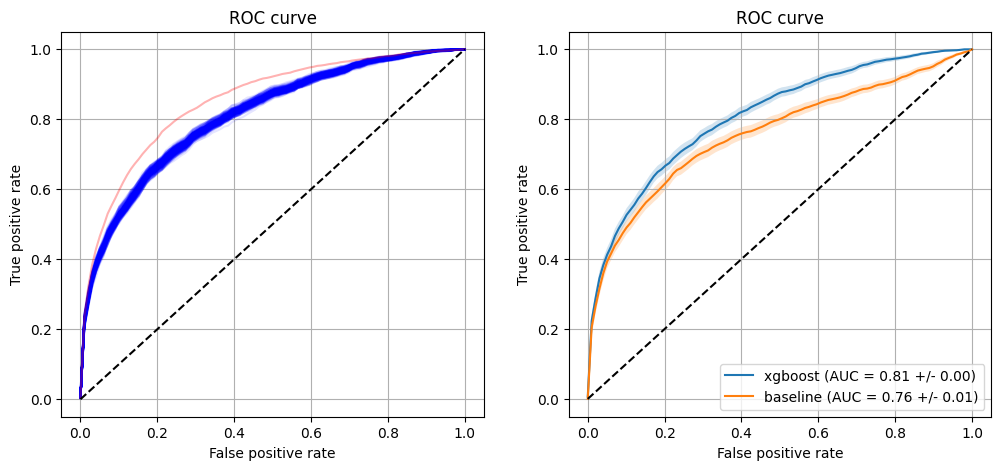

Z-score = 7.00
p-value = 0.00000000000124513554


In [11]:

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr_list)):
    plt.plot(fpr, tpr_list[i], 'b', alpha=0.1)
plt.plot(fpr, tpr_train, 'r', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
plt.fill_between(fpr, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr, tpr_mean, label=f'xgboost (AUC = {np.mean(auc_list):.2f} +/- {pd.Series(auc_list).std():.2f})')

#add baseline to the plot
df_baseline = pd.read_csv('data/results/baseline_roc.csv')
plt.fill_between(df_baseline.fpr, df_baseline.tpr - 2*df_baseline.tpr_std, df_baseline.tpr + 2*df_baseline.tpr_std, alpha=0.2)
plt.plot(df_baseline.fpr.values, df_baseline.tpr.values, label=f'baseline (AUC = {df_baseline.auc[0]:.2f} +/- {df_baseline.auc_std[0]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

Z_score = (np.mean(auc_list) - df_baseline.auc[0])/np.sqrt(df_baseline.auc_std[0]**2 + pd.Series(auc_list).std()**2)
print(f'Z-score = {Z_score:.2f}')
import scipy.stats
p_value = scipy.stats.norm.sf(abs(Z_score)) #one-sided
# p_value = 1 - 0.5*(1 + np.math.erf(Z_score/np.sqrt(2)))
print(f'p-value = {p_value:.20f}')


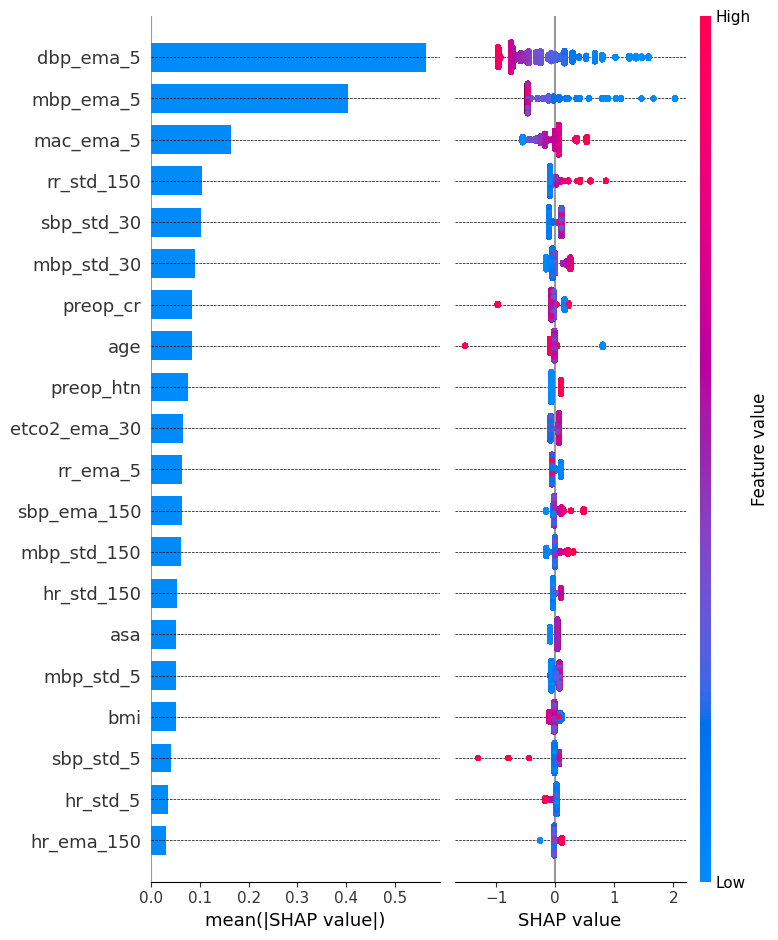

In [17]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 20

model = xgb.Booster()
model.load_model(f'data/models/xgb.json')
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data[FEATURE_NAME])
test_data = data[FEATURE_NAME]



# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean(|SHAP value|)')
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./report/figures/shap_xgboost.pdf', bbox_inches='tight', dpi=600)
plt.show()

,mbp_ema_5,mbp_std_5,sbp_ema_5,sbp_std_5,dbp_ema_5,dbp_std_5,hr_ema_5,hr_std_5,rr_ema_5,rr_std_5,...,time,time_before_IOH,caseid,dir0,age,bmi,asa,preop_cr,preop_htn,split
0,88.856438,0.981564,144.043488,2.167862,66.113815,0.936737,82.354401,2.005029,35.038620,36.356686,...,0 days 01:18:43,2,10,cases,72,23.796875,3,1.20,1,1
1,90.378693,1.629328,145.985077,2.573806,67.426338,1.221559,80.824692,1.042150,17.268320,14.627484,...,0 days 01:19:13,2,10,cases,72,23.796875,3,1.20,1,1
2,94.722420,2.106995,150.596054,2.794724,71.569160,2.041861,80.251122,0.564258,14.691422,5.288689,...,0 days 01:19:43,2,10,cases,72,23.796875,3,1.20,1,1
3,97.715408,1.646715,153.437408,2.291702,74.239624,1.643696,80.731865,0.474733,14.440847,1.931956,...,0 days 01:20:13,2,10,cases,72,23.796875,3,1.20,1,1
4,98.919258,0.938869,155.357727,2.194845,75.004784,1.026468,80.768387,0.439339,14.708391,0.809559,...,0 days 01:20:43,2,10,cases,72,23.796875,3,1.20,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129632,117.651711,0.961166,167.144882,4.678049,91.491875,1.349890,89.560013,5.964518,24.319275,17.092697,...,0 days 05:59:44,2,992,cases,56,18.296875,2,0.75,0,1
129633,115.714287,1.122698,164.516052,3.108883,89.122864,1.609588,90.384605,8.087052,33.527863,18.499054,...,0 days 06:00:14,2,992,cases,56,18.296875,2,0.75,0,1
129634,114.655022,0.810258,160.999954,4.589681,87.881241,2.350606,91.756378,6.129860,42.278339,23.617579,...,0 days 06:00:44,2,992,cases,56,18.296875,2,0.75,0,1
129635,117.269943,1.338288,167.420227,3.419563,89.846077,1.324821,90.215469,2.324946,22.602791,14.466634,...,0 days 06:01:14,2,992,cases,56,18.296875,2,0.75,0,1
